# 1. Initializations

## 1.1 General imports

In [ ]:
### Data management
import pandas as pd
import numpy as np
# import random
from functools import partial

### Machine Learning

# transformation
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, OneHotEncoder

# models
from sklearn.model_selection import train_test_split

# metrics and evaluation
from scipy.stats import probplot

### Data Viz

# graphical basics
import matplotlib.pyplot as plt
%matplotlib inline

# graphical seaborn
import seaborn as sns

# # graphical plotly
# import plotly.graph_objects as go
# import plotly.express as px
# # for jupyter notebook display management
# import plotly.io as pio
# pio.renderers.default = "notebook"

# graphical missingno
import missingno as msno


## 1.2 General dataframe functions

In [ ]:
import smartcheck.dataframe_common as dfc

## 1.3 General Classification functions

In [ ]:
import smartcheck.classification_common as cls

# 2. Loading and Data Quality

## 2.1 Loading of data sets and general exploration

### 2.1.1 VELO COMPTAGE (Main Data Set)

#### Loading and column management (columns names normalization)

In [ ]:
df_cpt_velo_raw = dfc.load_dataset_from_config('velo_comptage_data', sep=';')

if df_cpt_velo_raw is not None and isinstance(df_cpt_velo_raw, pd.DataFrame):
    df_cpt_velo = dfc.normalize_column_names(df_cpt_velo_raw)

>**Rapport**
>
>On a normalisé les noms de colonnes du data set afin de faciliter leur manipulation dans le code. La norme utilisée est de type **snake_case**
>  - Remplacement des caractères spéciaux et espaces par des underscores
>  - Conversion en minuscules

#### Search for general informations, duplicates and missing values stats

In [ ]:
display(df_cpt_velo.head())
dfc.log_general_info(df_cpt_velo)
nb_first, nb_total = dfc.detect_and_log_duplicates_and_missing(df_cpt_velo)
if nb_first != nb_total:
    print(dfc.duplicates_index_map(df_cpt_velo))

>**Rapport**
>
>Le dataset ***comptage velo*** présente **942554** observations (lignes) avec **16** variables (colonnes)
>  - Il ne possède **aucune** observation en doublon et toutes les observations possèdent **au moins** une information.
>  - La proportion d'informations manquantes (détail par variable ci-dessous) est de **3.38%**
>  - Pour notre objectif (identification des zones de trafic dense en vue d'aménagements), aucune variable ne semble donner une notion d'affluence par zone et horaire, donc nous serions face à une problématique d'analyse exploratoire par clusterisation sans supervision, si la problématique avait été de prédire le traffic alors la variable comptage_horaire aurait été une bonne variable cible (et le problème de type régression supervisée)
>
>| Variable | % informations manquantes |
>|-|-|
>| identifiant_du_compteur | 3.98% |
>| identifiant_du_site_de_comptage | 3.98% |
>| nom_du_site_de_comptage | 3.98% |
>| date_d_installation_du_site_de_comptage | 3.98% |
>| lien_vers_photo_du_site_de_comptage | 5.02% |
>| coordonnees_geographiques | 3.98% |
>| identifiant_technique_compteur | 5.02% |
>| id_photos | 5.02% |
>| test_lien_vers_photos_du_site_de_comptage | 5.02% |
>| id_photo_1 | 5.02% |
>| url_sites | 3.98% |
>| type_dimage | 5.02% |

In [ ]:
# Représentation des valeur NA graphiquement
msno.matrix(df_cpt_velo)

>**Rapport**
>
>Le graphique de répartition des valeur manquantes ci-après montre que les observations manquantes sont regroupées sur des plages d'index contigues ce qui facilite l'identification des causes en regroupant sur les absences de valeur d'un des colonnes suivantes:
> - lien_vers_photo_du_site_de_comptage
> - identifiant_technique_compteur
> - id_photos
> - test_lien_vers_photos_du_site_de_comptage
> - id_photo_1
> - type_dimage
>
>On observe que l'absence de valeur concerne un cluster de toutes les colonnes ci-dessus et également un autre cluster avec les colonnes additionnelles suivantes:
> - identifiant_du_compteur
> - identifiant_du_site_de_comptage
> - nom_du_site_de_comptage
> - date_d_installation_du_site_de_comptage
> - coordonnees_geographiques
> - url_sites
>
>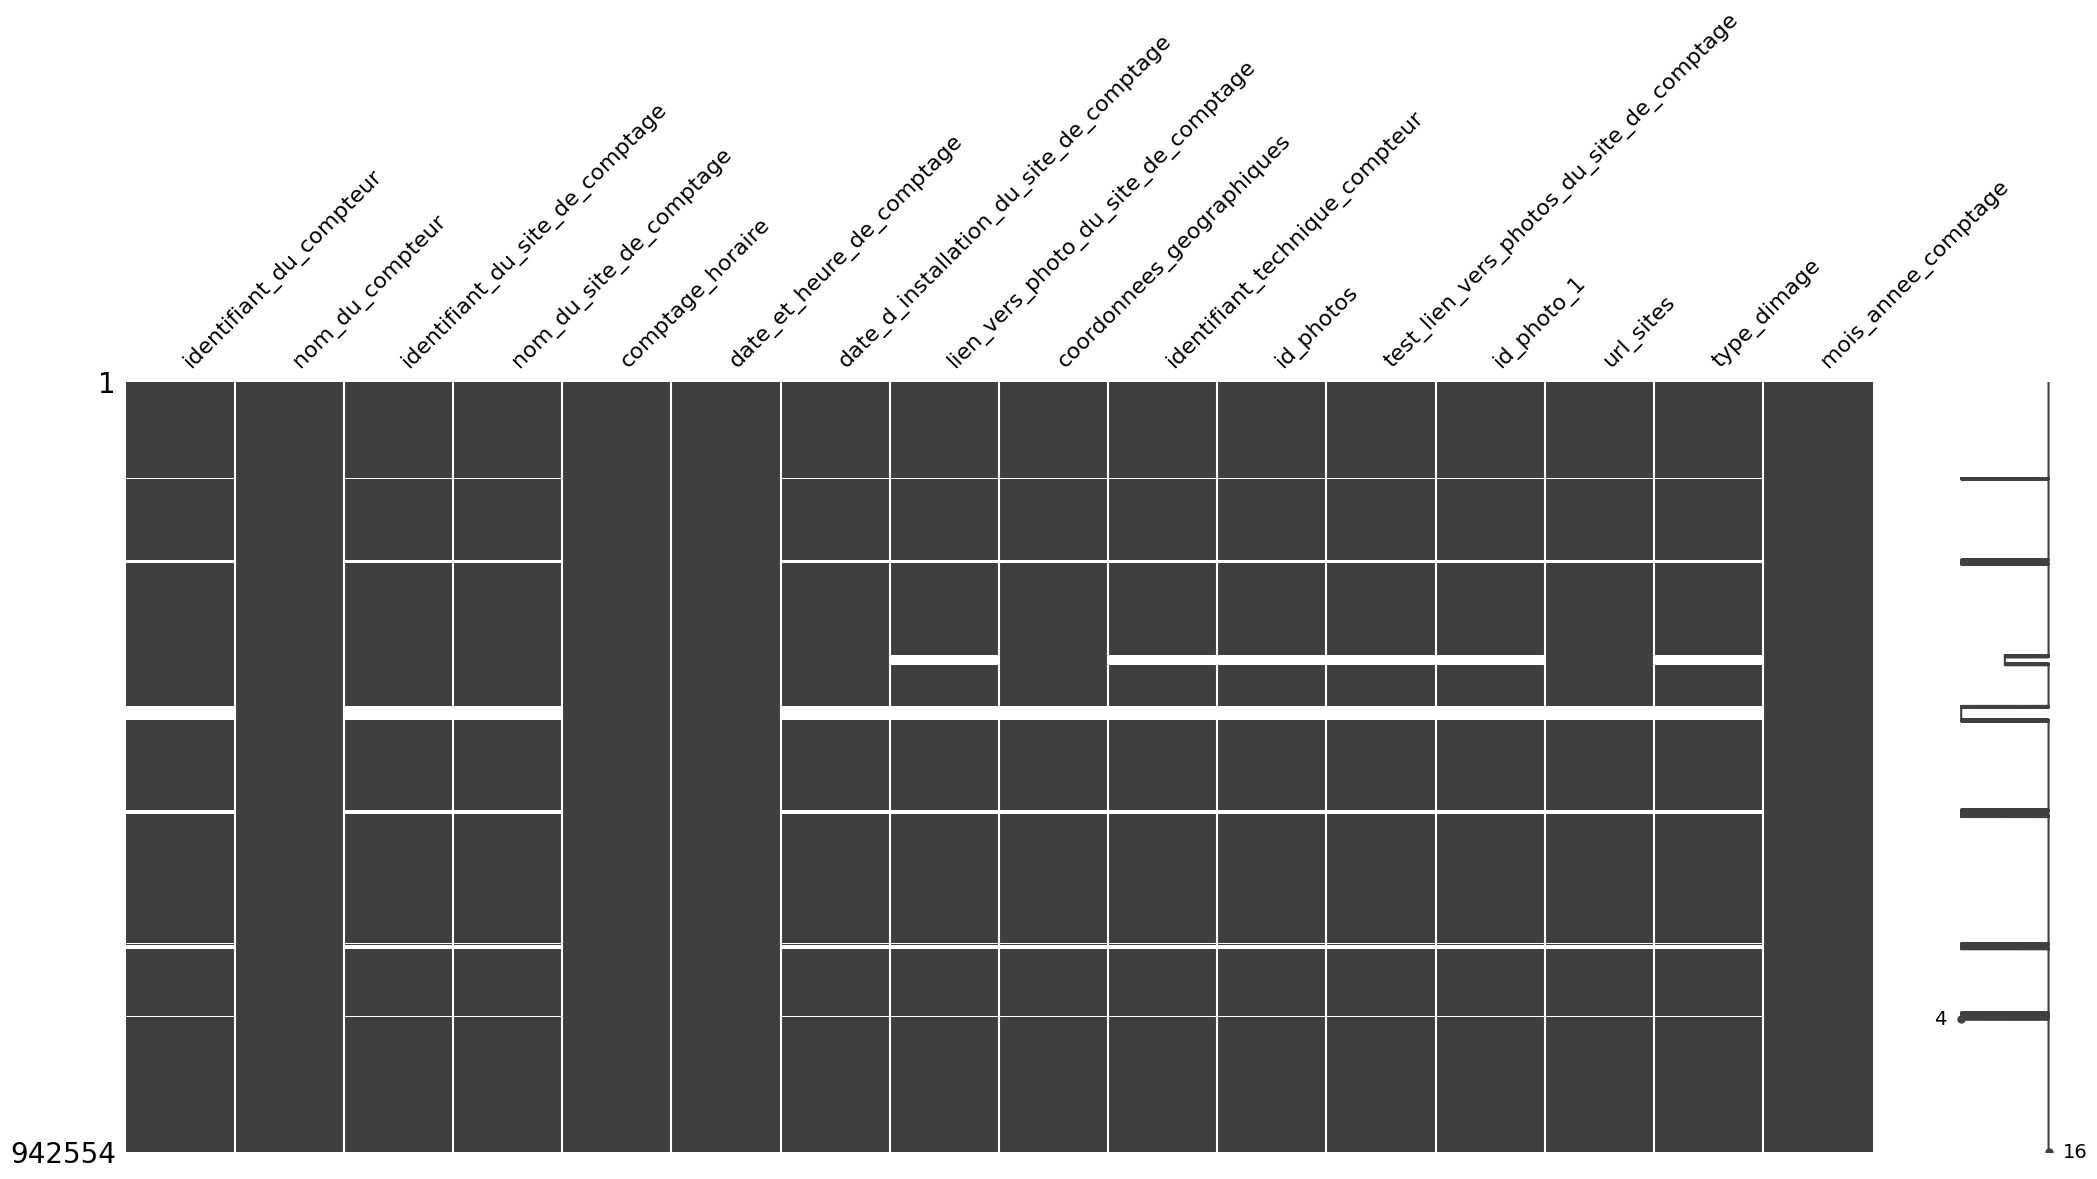

#### Missing value correlation exploration

In [ ]:
liste_compteur_na = df_cpt_velo[df_cpt_velo.lien_vers_photo_du_site_de_comptage.isna()].groupby('nom_du_compteur').count()
display(liste_compteur_na, liste_compteur_na.index.to_list())

>**Rapport**
>
>On constate que seuls quelques noms de compteur concentrent l'ensemble des observations manquantes (ci-après) et que pour ces nom de compteur, les informations absentes le sont totalement
>
>Les noms peuvent être inférés et recoupés avec la base [Comptage vélo - Compteurs](https://parisdata.opendatasoft.com/explore/dataset/comptage-velo-compteurs/table/?disjunctive.counter&disjunctive.name&disjunctive.nom_compteur&disjunctive.id&disjunctive.id_compteur)
>
> - '10 avenue de la Grande Armée 10 avenue de la Grande Armée [Bike IN]'
> - '10 avenue de la Grande Armée 10 avenue de la Grande Armée [Bike OUT]'
> - '27 quai de la Tournelle 27 quai de la Tournelle Vélos NO-SE'
> - '27 quai de la Tournelle 27 quai de la Tournelle Vélos SE-NO'
> - '35 boulevard de Ménilmontant NO-SE' (seul site du lot possédant en plus les données) :
>   - url_sites
>   - coordonnees_geographiques
>   - date_d_installation_du_site_de_comptage
>   - nom_du_site_de_comptage
>   - identifiant_du_site_de_comptage
>   - identifiant_du_compteur
> - 'Face au 48 quai de la marne Face au 48 quai de la marne Vélos NE-SO'
> - 'Face au 48 quai de la marne Face au 48 quai de la marne Vélos SO-NE'
> - 'Pont des Invalides N-S'
> - 'Quai des Tuileries Quai des Tuileries Vélos NO-SE'
> - 'Quai des Tuileries Quai des Tuileries Vélos SE-NO'
> - 'Totem 64 Rue de Rivoli Totem 64 Rue de Rivoli Vélos E-O'
> - 'Totem 64 Rue de Rivoli Totem 64 Rue de Rivoli Vélos O-E'

#### Missing value correlation for "avenue de la Grande Armée"

In [ ]:
mask = df_cpt_velo.nom_du_compteur.str.contains("avenue de la Grande Armée")
col_count = ['nom_du_compteur', 'coordonnees_geographiques']
display(df_cpt_velo[mask].groupby(col_count)[col_count].count())

mask = df_cpt_velo.nom_du_compteur.str.contains("avenue de la Grande Armée")
col_count = ['nom_du_compteur', 'mois_annee_comptage']
display(df_cpt_velo[mask].groupby(col_count)[col_count].count())

>**Rapport**
>
>L'analyse pour les compteurs avec infos manquantes "avenue de la grande armée" montre qu'ils sont une version préliminaire de "10 avenue de la Grande Armée SE-NO" (à partir de mars 2025 ils sont regroupés sur 10 avenue de la Grande Armée SE-NO et n'émettent plus d'information)
> - "10 avenue de la Grande Armée 10 avenue de la Grande Armée [Bike IN]" à propager vers "10 avenue de la Grande Armée SE-NO"
> - "10 avenue de la Grande Armée 10 avenue de la Grande Armée [Bike OUT]" à propager vers "10 avenue de la Grande Armée SE-NO"
>
>Nous pouvons donc propager les bonnes informations manquante depuis la source et renommer correctement les compteurs ci-dessus

#### Missing value correlation for "27 quai de la Tournelle"

In [ ]:
mask = df_cpt_velo.nom_du_compteur.str.contains("27 quai de la Tournelle")
col_count = ['nom_du_compteur', 'coordonnees_geographiques']
display(df_cpt_velo[mask].groupby(col_count)[col_count].count())

mask = df_cpt_velo.nom_du_compteur.str.contains("27 quai de la Tournelle")
col_count = ['nom_du_compteur', 'mois_annee_comptage']
display(df_cpt_velo[mask].groupby(col_count)[col_count].count())

>**Rapport**
>
>L'analyse pour les compteurs avec infos manquantes "quai de la Tournelle" montre un simple coquille sur période de 4 mois des compteurs officiels (entre novembre 2024 et février 2025)
> - "27 quai de la Tournelle 27 quai de la Tournelle Vélos NO-SE" à propager vers "27 quai de la Tournelle NO-SE"
> - "27 quai de la Tournelle 27 quai de la Tournelle Vélos SE-NO" à propager vers "27 quai de la Tournelle SE-NO" 
>
>Nous pouvons donc propager les bonnes informations manquante depuis la source et renommer correctement les compteurs ci-dessus

#### Missing value correlation for "Face au 48 quai de la marne"

In [ ]:
mask = df_cpt_velo.nom_du_compteur.str.contains("Face au 48 quai de la marne")
col_count = ['nom_du_compteur', 'coordonnees_geographiques']
display(df_cpt_velo[mask].groupby(col_count)[col_count].count())

mask = df_cpt_velo.nom_du_compteur.str.contains("Face au 48 quai de la marne")
col_count = ['nom_du_compteur', 'mois_annee_comptage']
display(df_cpt_velo[mask].groupby(col_count)[col_count].count())

>**Rapport**
>
>L'analyse pour les compteurs avec infos manquantes "Face au 48 quai de la marne" montre un simple coquille sur période de 4 mois des compteurs officiels (entre novembre 2024 et février 2025)
> - "Face au 48 quai de la marne Face au 48 quai de la marne Vélos NE-SO" à propager vers "Face au 48 quai de la marne NE-SO"
> - "Face au 48 quai de la marne Face au 48 quai de la marne Vélos SO-NE" à propager vers "Face au 48 quai de la marne SO-NE"
>
>Nous pouvons donc propager les bonnes informations manquante depuis la source et renommer correctement les compteurs ci-dessus

#### Missing value correlation for "Pont des Invalides"

In [ ]:
mask = df_cpt_velo.nom_du_compteur.str.contains("Pont des Invalides")
col_count = ['nom_du_compteur', 'coordonnees_geographiques']
display(df_cpt_velo[mask].groupby(col_count)[col_count].count())

mask = df_cpt_velo.nom_du_compteur.str.contains("Pont des Invalides")
col_count = ['nom_du_compteur', 'mois_annee_comptage']
display(df_cpt_velo[mask].groupby(col_count)[col_count].count())

>**Rapport**
>
>L'analyse pour les compteurs avec infos manquantes "Pont des Invalides" montre un simple changement de nom d'un des compteurs (entre mars 2024 et février 2025)
> - "Pont des Invalides N-S" à propager vers "Pont des Invalides (couloir bus) N-S"
>
>Nous pouvons donc propager les bonnes informations manquante depuis la source et renommer correctement le compteur ci-dessus

#### Missing value correlation for "Quai des Tuileries"

In [ ]:
mask = df_cpt_velo.nom_du_compteur.str.contains("Quai des Tuileries")
col_count = ['nom_du_compteur', 'coordonnees_geographiques']
display(df_cpt_velo[mask].groupby(col_count)[col_count].count())

mask = df_cpt_velo.nom_du_compteur.str.contains("Quai des Tuileries")
col_count = ['nom_du_compteur', 'mois_annee_comptage']
display(df_cpt_velo[mask].groupby(col_count)[col_count].count())

>**Rapport**
>
>L'analyse pour les compteurs avec infos manquantes "Quai des Tuileries" montre un simple coquille sur période de 4 mois des compteurs officiels (entre novembre 2024 et février 2025)
> - "Quai des Tuileries Quai des Tuileries Vélos NO-SE" à propager vers "Quai des Tuileries NO-SE"
> - "Quai des Tuileries Quai des Tuileries Vélos SE-NO" à propager vers "Quai des Tuileries SE-NO"
>
>Nous pouvons donc propager les bonnes informations manquante depuis la source et renommer correctement les compteurs ci-dessus

#### Missing value correlation for "Totem 64 Rue de Rivoli"

In [ ]:
mask = df_cpt_velo.nom_du_compteur.str.contains("Totem 64 Rue de Rivoli")

col_count = ['nom_du_compteur', 'coordonnees_geographiques']
display(df_cpt_velo[mask].groupby(col_count)[col_count].count())

mask = df_cpt_velo.nom_du_compteur.str.contains("Totem 64 Rue de Rivoli")
col_count = ['nom_du_compteur', 'mois_annee_comptage']
display(df_cpt_velo[mask].groupby(col_count)[col_count].count())

>**Rapport**
>
>L'analyse pour les compteurs avec infos manquantes "Totem 64 Rue de Rivoli" montre un simple coquille sur période d'un an des compteurs officiels (entre mars 2024 et février 2025)
> - "Totem 64 Rue de Rivoli Totem 64 Rue de Rivoli Vélos E-O" à propager vers "Totem 64 Rue de Rivoli E-O"
> - "Totem 64 Rue de Rivoli Totem 64 Rue de Rivoli Vélos O-E" à propager vers "Totem 64 Rue de Rivoli O-E" 
>
>Nous pouvons donc propager les bonnes informations manquante depuis la source et renommer correctement les compteurs ci-dessus

#### Missing value correlation for "boulevard de Ménilmontant"

In [ ]:
mask = df_cpt_velo.nom_du_compteur.str.contains("boulevard de Ménilmontant")
col_count = [
    'nom_du_compteur', 
    'lien_vers_photo_du_site_de_comptage',
    'identifiant_technique_compteur',
    'id_photos',
    'test_lien_vers_photos_du_site_de_comptage',
    'id_photo_1',
    'type_dimage',
]
display(df_cpt_velo[mask].groupby(col_count, dropna=False)[col_count].count())

agg_counts = (
    df_cpt_velo
    .groupby(col_count, dropna=False)
    .size()  # équivalent à count(), mais plus direct
    .reset_index(name='nb_occurrences')
    .groupby('nom_du_compteur')['nb_occurrences']
    .count()
    .reset_index(name='nb_occurrences')
)
print(f"Nombre d'agrégats uniques sur les colonnes {col_count} regroupés par 'nom_du_compteur'")
display(agg_counts.head())
print("En filtrant sur les regroupements de ces aggrégats supérieurs strictement à 1"
      " (identification des groupes de colonnes avec plusieurs combinaisons de valeurs)")
display(agg_counts.loc[agg_counts['nb_occurrences'] > 1])

>**Rapport**
>
>L'analyse pour les compteurs avec infos manquantes "boulevard de Ménilmontant" montre que seules les données spécifiques suivantes sont manquantes de manière uniforme
> - 'lien_vers_photo_du_site_de_comptage'
> - 'identifiant_technique_compteur'
> - 'id_photos'
> - 'test_lien_vers_photos_du_site_de_comptage'
> - 'id_photo_1'
> - 'type_dimage'
>
>Nous décidons de ne pas faire d'action sur ces colonnes car non pertinentes et nous ne disposons pas de la source 

#### Analysis of 'identifiant_du_compteur', 'identifiant_du_site_de_comptage', 'nom_du_compteur', 'nom_du_site_de_comptage'

In [ ]:
df_identifiants = df_cpt_velo[['identifiant_du_compteur', 'identifiant_du_site_de_comptage', 'nom_du_compteur', 'nom_du_site_de_comptage', 'comptage_horaire']]
df_cpt_grouped = df_identifiants.groupby(['identifiant_du_compteur', 'nom_du_compteur']).comptage_horaire.count().reset_index()
df_site_grouped = df_identifiants.groupby(['identifiant_du_site_de_comptage', 'nom_du_site_de_comptage']).identifiant_du_compteur.count().reset_index()
print("Nombre de doublon sur les couples identifiant_du_compteur/nom_du_compteur:",df_cpt_grouped.duplicated().sum())
display(df_cpt_grouped)
print("Nombre de doublon sur les couples identifiant_du_site_de_comptage/nom_du_site_de_comptage:", df_site_grouped.duplicated().sum())
display(df_site_grouped)

In [ ]:
dfc.display_variable_info(df_cpt_velo.identifiant_du_compteur)
dfc.display_variable_info(df_cpt_velo.nom_du_compteur)

In [ ]:
dfc.display_variable_info(df_cpt_velo.identifiant_du_site_de_comptage)
dfc.display_variable_info(df_cpt_velo.nom_du_site_de_comptage)

In [ ]:
mask = df_cpt_velo.apply(lambda row: 
                  True if pd.isna(row.nom_du_site_de_comptage) else 
                  True if row.nom_du_site_de_comptage in row.nom_du_compteur else 
                  False, axis=1)
display("lignes dont le nom du site n'est pas complètement inclus dans le nom du compteur",df_cpt_velo[~mask])

In [ ]:
custom_diff = partial(
    dfc.extract_difference,
    source_col="nom_du_site_de_comptage",
    target_col="nom_du_compteur",
    # nan_placeholder="__NaN__",
    # not_found_placeholder="__NOT_FOUND__"
)

# Ajout d'une nouvelle colonne orientation compteur extraite de la fin du nom du compteur
df_cpt_velo["orientation_compteur"] = df_cpt_velo.apply(
    custom_diff,
    axis=1
)

In [ ]:
df_cpt_velo.info()

#### Analysis of 'orientation_compteur'

In [ ]:
dfc.display_variable_info(df_cpt_velo.orientation_compteur)

>**Rapport**
>
>On peut confirmer que les variables identifiant_du_compteur/nom_du_compteur et identifiant_du_site_de_comptage/nom_du_site_de_comptage ont une relation 1-1. Il faudra donc traiter ces informations redondantes et décider laquelle conserver
>
>Les variables liées aux "noms" (compteur ou site de comptage), contiennent plus d'information exploitables que leur contrepartie identifiant numérique notamment des information géographiques et pour le nom du compteur une information additionnelle d'orientation dont voici les valeurs extraites sur tout le data set (avec leur répartitions normalisée)
>
>|orientation_compteur|normalized count|
>|-|-|
>| NE-SO        |  0.164345|
>| SO-NE        |  0.153553|
>| NO-SE        |  0.150981|
>| SE-NO        |  0.130895|
>| N-S          |  0.097736|
>| E-O          |  0.095101|
>| S-N          |  0.093293|
>| O-E          |  0.074274|
>|\[nom_du_site_de_comptage\] EMPTY  |  0.039822|

#### Analysis of 'type_image', 'url_sites' , 'id_photo_1'

In [ ]:
dfc.display_variable_info(df_cpt_velo.type_dimage)
dfc.display_variable_info(df_cpt_velo.id_photo_1)
dfc.display_variable_info(df_cpt_velo.url_sites)

#### Global description and correlation for quantitative variables

In [ ]:
df_cpt_velo_desc = df_cpt_velo.select_dtypes(include=np.number).describe()
display(df_cpt_velo_desc)
df_cpt_velo_cr = df_cpt_velo.select_dtypes(include=np.number).corr()
display(df_cpt_velo_cr)

>**Rapport**
>
>Description des variables quantitatives brutes
>
>|Stat   |  comptage_horaire   |    identifiant_du_site_de_comptage   |        
>|-|-|-|
>|count	| 942554.000000      |    9.050200e+05	                    |
>|mean	| 77.879018          |    1.348171e+08	                    |
>|std    |  106.928569         |    7.579019e+07	                    |
>|min    |  0.000000           |    1.000031e+08	                    |
>|25%    |  11.000000          |    1.000475e+08	                    |
>|50%    |  42.000000          |    1.000560e+08	                    |
>|75%    |  97.000000          |    1.000563e+08	                    |
>|max    |  3070.000000        |    3.000303e+08	                    |

## 2.2 Data quality refinement

### 2.2.1 VELO COMPTAGE (Main Dataset)

#### Sauvegarde en mémoire avant remaniement

In [ ]:
# Original backup and duplicates management
df_cpt_velo_orig = df_cpt_velo.copy()

In [ ]:
# Restore (if needed to recover)
df_cpt_velo = df_cpt_velo_orig.copy()

#### Traitement des valeurs manquantes par propagation des infos des nom de compteur identifié (source->cible)

In [ ]:
# colonnes à copier globalement pour tous les clusters de nom de compteur depuis une source peuplée
colonnes_a_copier = [
    'nom_du_compteur',
    'identifiant_du_compteur',
    'identifiant_du_site_de_comptage', 
    'nom_du_site_de_comptage',
    'date_d_installation_du_site_de_comptage',
    'coordonnees_geographiques',
    'url_sites',
]
dico_repl = {
    'cibles':[
        '10 avenue de la Grande Armée 10 avenue de la Grande Armée [Bike IN]',
        '10 avenue de la Grande Armée 10 avenue de la Grande Armée [Bike OUT]',
        '27 quai de la Tournelle 27 quai de la Tournelle Vélos NO-SE',
        '27 quai de la Tournelle 27 quai de la Tournelle Vélos SE-NO',
        "Face au 48 quai de la marne Face au 48 quai de la marne Vélos NE-SO",
        "Face au 48 quai de la marne Face au 48 quai de la marne Vélos SO-NE",
        "Pont des Invalides N-S",
        "Quai des Tuileries Quai des Tuileries Vélos NO-SE",
        "Quai des Tuileries Quai des Tuileries Vélos SE-NO",
        "Totem 64 Rue de Rivoli Totem 64 Rue de Rivoli Vélos E-O",
        "Totem 64 Rue de Rivoli Totem 64 Rue de Rivoli Vélos O-E",
    ],
    'sources':[
        '10 avenue de la Grande Armée SE-NO',
        '10 avenue de la Grande Armée SE-NO',
        '27 quai de la Tournelle NO-SE',
        '27 quai de la Tournelle SE-NO',
        "Face au 48 quai de la marne NE-SO",
        "Face au 48 quai de la marne SO-NE",
        "Pont des Invalides (couloir bus) N-S",
        "Quai des Tuileries NO-SE",
        "Quai des Tuileries SE-NO",
        "Totem 64 Rue de Rivoli E-O",
        "Totem 64 Rue de Rivoli O-E",
    ],
}

for source, cible in zip(dico_repl['sources'], dico_repl['cibles']):
    # Condition source : on prend la première ligne correspondante
    cond_source = (df_cpt_velo['nom_du_compteur'] == source)
    df_source = df_cpt_velo.loc[cond_source]
    print(f"source [{source}]\ncible [{cible}]\nshape source [{df_source.shape}]")
    if df_source.empty:
        print(f"⚠️ Aucun compteur source trouvé pour: {source}")
        continue
    # Condition cible : les lignes à modifier
    cond_cible = (df_cpt_velo['nom_du_compteur'] == cible)
    df_cible = df_cpt_velo.loc[cond_cible]
    if df_cible.empty:
        print(f"⚠️ Aucun compteur cible trouvé pour: {cible}")
        continue
    display("### Contenu utilisé ###",df_source.iloc[0])
    ligne_source = df_source.iloc[0]  # première occurrence
    # Affectation des valeurs des colonnes choisies depuis la ligne source vers les lignes cibles
    df_cpt_velo.loc[cond_cible, colonnes_a_copier] = ligne_source[colonnes_a_copier].values

In [ ]:
# Représentation des valeur NA graphiquement
msno.matrix(df_cpt_velo)

>**Rapport**
>
>Après traitement des noms de station seules les colonnes spécifiques au compteur sont encore avec valeurs manquantes et nous décidons de les abandonner
>
>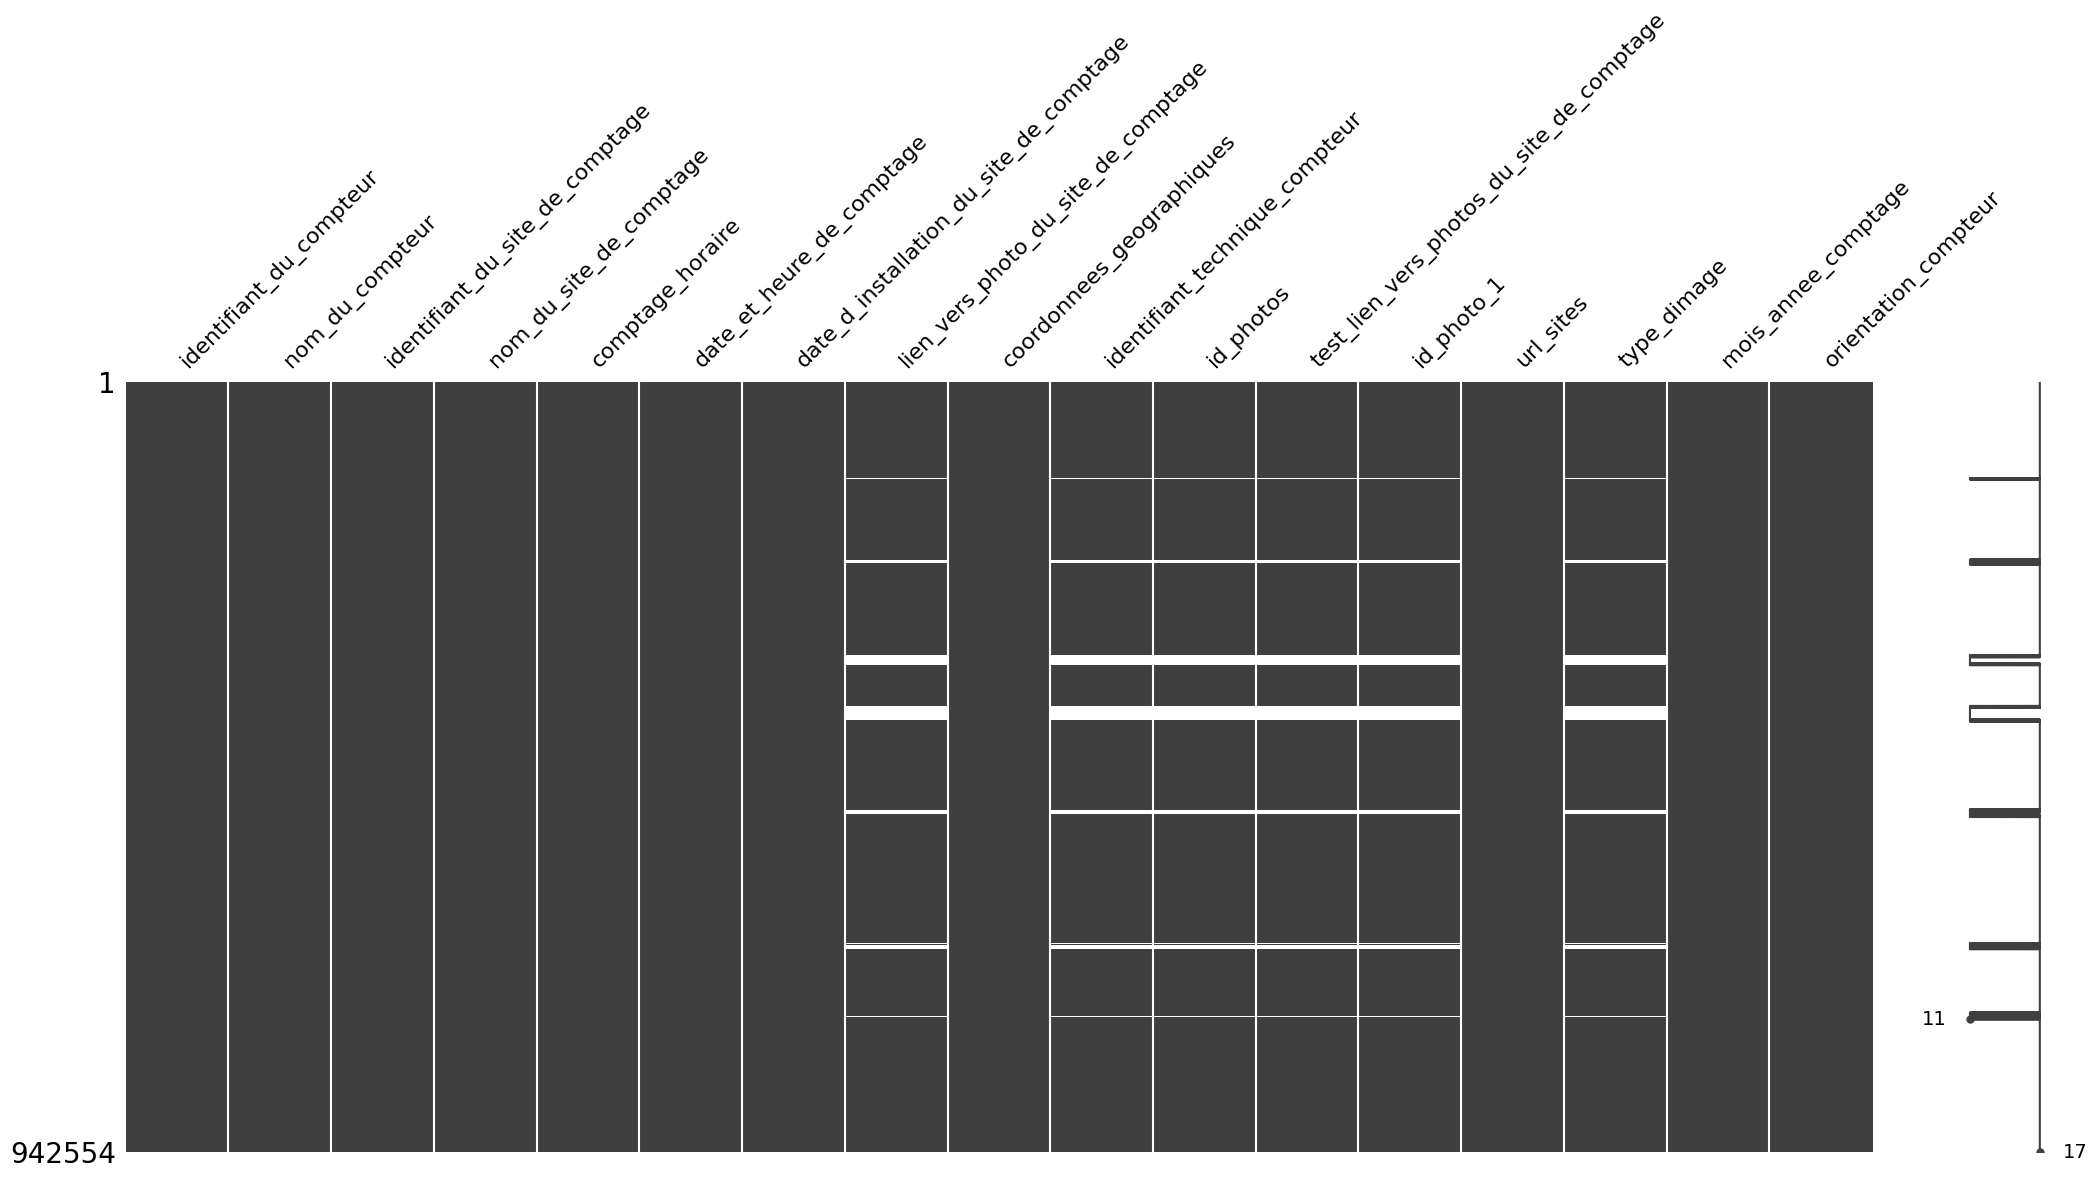

#### Suppression des colonnes n'apportant pas de valeur explicative

In [ ]:
col_suppr = [
    'lien_vers_photo_du_site_de_comptage',
    'identifiant_technique_compteur',
    'id_photos',
    'test_lien_vers_photos_du_site_de_comptage',
    'id_photo_1',
    'date_d_installation_du_site_de_comptage',
    'url_sites',
    'type_dimage',
]
df_cpt_velo = df_cpt_velo.drop(columns=col_suppr)
msno.matrix(df_cpt_velo)

>**Rapport**
>
>La suppression des colonnes sans valeur explicative (relative a un compteur unique multipliées X fois) permet de commencer a travailler sur les types et les distributions et correlations des données restantes.
>
>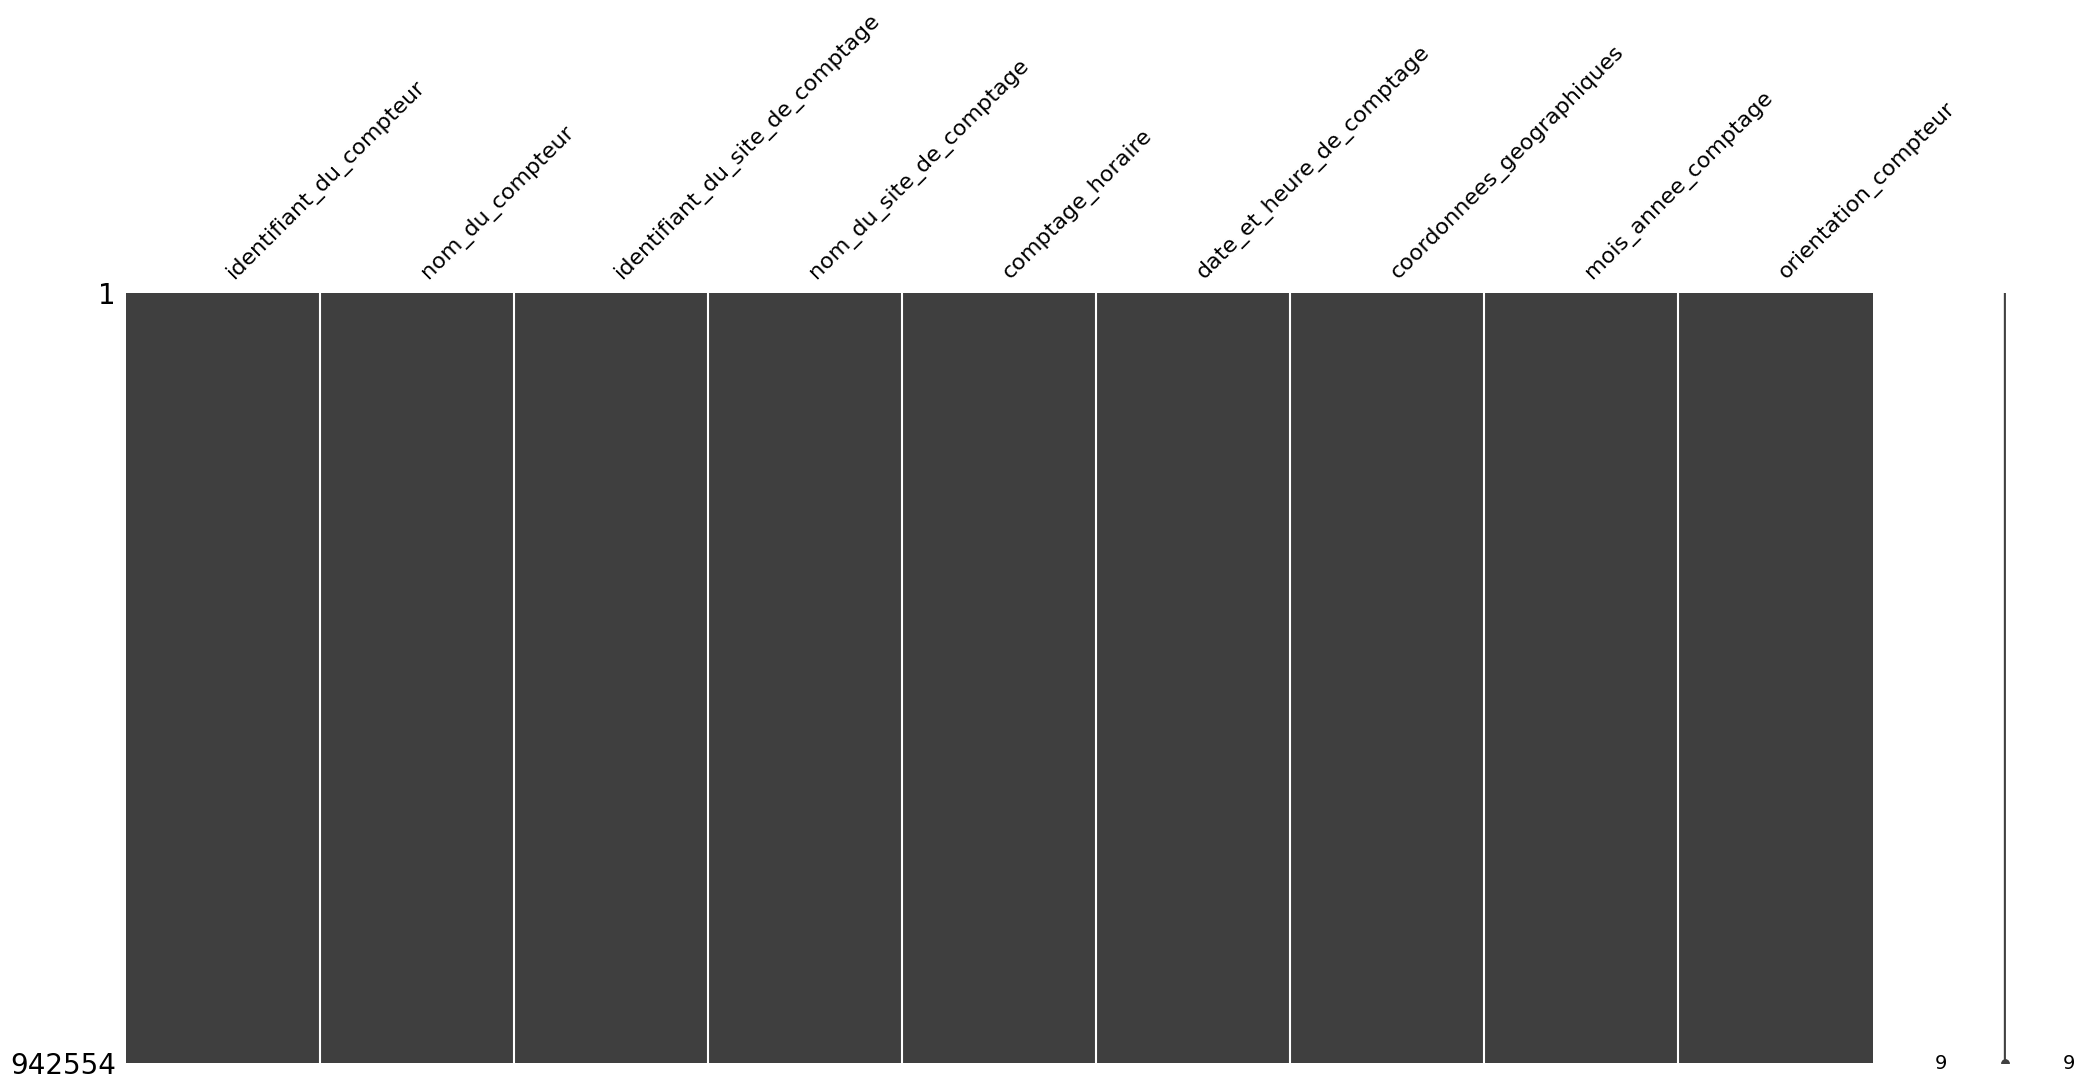

# 3. Data Viz' and Analysis

## 3.1 General Data Viz'

In [ ]:
# Vérificationn graphique de la répartition en loi normale de chaque données numérique
for col in df_cpt_velo.select_dtypes(include='number').columns:
    probplot(df_cpt_velo[col], dist="norm", plot=plt)
    plt.suptitle(f"Column {col}")
    plt.show()

## 3.2 Quantitative mono variable distribution

In [ ]:
dd

## 3.3 Qualitative mono variable distribution

In [ ]:
dd

## 3.4 Qualitative multi variable distribution

## 3.5 Quantitative multi variable correlation

# 4. Division in Train/Test

In [ ]:
# df_disp_velib = df_disp_velib_orig.copy()

In [ ]:
# (temporaire) Ajustement : enlever les variables non retravaillées pour le moment
# df_cpt_velo = df_cpt_velo.drop(columns=['identifiant_station',
#                                         'nom_station', 
#                                         'actualisation_de_la_donnee', 
#                                         'coordonnees_geographiques', 
#                                         'nom_communes_equipees',
#                                         'code_insee_communes_equipees',
#                                         'station_opening_hours'])

In [ ]:
# Separation features (X) et target (y) pour train et test
target_col = 'comptage_horaire'
features = df_cpt_velo.drop(target_col, axis=1)
target = df_cpt_velo[target_col]
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=66)
print("Train Set (X/y):", X_train.shape, y_train.shape)
print("Test Set (X/y):", X_test.shape, y_test.shape)

# 5. Feature engineering
Règle d'or : Toute opération qui "apprend" des données (i.e. utilise l’ensemble des valeurs pour calculer quelque chose) doit être faite après le split train/test — c’est-à-dire uniquement sur le train.

| Type de transformation                                                                                    | À faire avant le split ?                    | Détails                                                            |
| --------------------------------------------------------------------------------------------------------- | ------------------------------------------- | ------------------------------------------------------------------ |
| ✅ Création de features basées sur les colonnes existantes (ex: `BMI = weight / height²`)                  | **Avant**                                   | Pas de risque de fuite car c’est purement déterministe.            |
| ⚠️ Calculs dépendant de la distribution (moyennes, encodage fréquentiel, imputation par la médiane, etc.) | **Après** (sur le train uniquement)         | Risque de fuite de données si appliqué sur l’ensemble avant split. |
| ✅ Ajout de features exogènes fixes (données météo, géographiques, calendaires, etc.)                      | **Avant**                                   | Pas de dépendance au `target` ni à la répartition train/test.      |
| ⚠️ Encoding (`LabelEncoder`, `OneHot`, `TargetEncoding`, etc.)                                            | **Fit sur train, transform sur train/test** | Toujours fitter uniquement sur le `train`.                         |
| ⚠️ Standardisation / normalisation (Scaler)                                                               | **Fit sur train, transform sur train/test** | Pareil : `.fit()` sur train, `.transform()` sur test.              |


## 5.1 Modification localisées sur les variables d'entrainement

In [ ]:
# Exemple de modification localisée en fonction de la proximité à la médiane d'autre variables
# mask = (
#     (train['Gender'].isna()) &
#     (abs(train['Age'] - 30) > abs(train['Age'] - 41)) & # L’âge est plus proche de 41 que de 30
#     (train['Previously_Insured'] == 0) & # La personne n’était pas assurée auparavant
#     (train['Vehicle_Damage'] == 1) # Elle a subi un dommage sur son véhicule
# )
# train.loc[mask, 'Gender'] = 0

In [ ]:
# Exemple de modification par répartition spécifique entre deux valeurs 0 et 1
# proportion_tab = [0] * 55 + [1] * 45
# mask = (
#     (train['Gender'].isna()) &
# )
# train.loc[mask, 'Gender'] = train.loc[mask, 'Gender'].apply(lambda x: random.choice(proportion))

## 5.2 Preprocessing

### 5.2.1 Scaling (données quantitatives)

In [ ]:
# - ni outlier ni distribution loi normale : min/max
# - sans outlier mais distribution loi normale : standard
# - avec outlier : Robust 
mm_scal = MinMaxScaler()
r_scal = RobustScaler()
s_scal = StandardScaler()

# r_scal_col = ['']
# df_cpt_velo[r_scal_col] = s_scal.fit_transform(df_cpt_velo[r_scal_col])

### 5.2.1 Encoding (données qualitatives)

In [ ]:
# Technique                 Type                Colonnes créées     Principe
# get_dummies()	            Nominale	        N (ou N–1)	        Binaire par modalité
# OneHotEncoder	            Nominale, Cyclique	N	                Colonne 0/1 par modalité
# Sum Encoding	            Nominale	        N–1	                Différence avec moyenne globale
# Helmert Encoding	        Nominale	        N–1	                Contraste avec moyenne des modalités précédentes
# Backward Difference	    Ordinale	        N–1	                Contraste avec moyenne des modalités suivantes
# Binary Encoding	        Nominale	        log₂(N)	            Encodage binaire de l’index
# Hashing Encoding	        Nominale	        n_components	    Hash des modalités sur colonnes fixes
# Label Encoding	        Ordinale	        1	                Entier arbitraire
# Ordinal Encoding	        Ordinale	        1	                Rang croissant des modalités
# Target Encoding	        Nominale/Ordinale	1	                Moyenne de la cible par modalité
# Mean Encoding	            Nominale/Ordinale	1	                Idem Target Encoding
# Frequency Encoding	    Nominale/Ordinale	1	                Fréquence d'apparition
# Leave-One-Out	            Nominale/Ordinale	1	                Moyenne de la cible, sauf ligne courante
# James-Stein Encoding	    Nominale/Ordinale	1	                Moyenne pondérée par variance intercatégorie
# M-Estimate Encoding	    Nominale/Ordinale	1	                Moyenne cible lissée vers moyenne globale
# Probability Ratio	        Ordinale, binaire	1	                Log du ratio de probas classe 1 / classe 0
# WOE Encoding	            Ordinale, binaire	1	                Log( %positif / %négatif )
# Thermometer Encoding	    Ordinale	        N	                1 si la modalité est ≤ à une valeur
# Trigonométrique (sin/cos)	Cyclique	        2	                Encode la cyclicité
# Fourier / Radial	        Cyclique	        Variable	        Approximation périodique (base)

ohe_enc_col = ['']
ohe_enc = OneHotEncoder(handle_unknown='ignore', sparse_output = False)
# # Appliquer OneHotEncoder
# X_train_enc_cat = ohe_enc.fit_transform(X_train[ohe_enc_col])
# X_test_enc_cat = ohe_enc.transform(X_test[ohe_enc_col])
# # Ajout des colonnes encodées à un DataFrame car le resultat de enc.fit/transform estun ndarray sans index/colonnes
# X_train_cat_df = pd.DataFrame(X_train_enc_cat, columns=ohe_enc.get_feature_names_out(ohe_enc_col), index=X_train.index)
# X_test_cat_df = pd.DataFrame(X_test_enc_cat, columns=ohe_enc.get_feature_names_out(ohe_enc_col), index=X_test.index)
# # Suppression des colonnes catégoriques originales et ajout des colonnes encodées
# X_train = pd.concat([X_train.drop(columns=ohe_enc_col), X_train_cat_df], axis=1)
# X_test = pd.concat([X_test.drop(columns=ohe_enc_col), X_test_cat_df], axis=1)